In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib inline

In [2]:
# manual input

refPEEQ_file = 'compPEEQ_outPunch.csv'   # input file for strain path of macro model (component model)
box_displace = 0.4                       # maximum displacement ratio to boxsize
timeStep_odb = 100                       # number of timeframe

In [3]:
# load data

# mises = pd.read_csv('mises.csv').values
peeq = pd.read_csv('peeq.csv').values
triax = pd.read_csv('triax.csv').values
lode = pd.read_csv('lode.csv').values
volume = pd.read_csv('volume.csv').values

**Initialize data**

In [4]:
# initialize component data

refPEEQ = np.genfromtxt(refPEEQ_file, delimiter=',', skip_header=1)

compTriax = [eta for [peeq, eta, theta] in refPEEQ]
compLode = [theta for [peeq, eta, theta] in refPEEQ]
compPeeq = [peeq for [peeq, eta, theta] in refPEEQ]

In [5]:
# initialize box displacement data

displace_interval = box_displace/timeStep_odb

timeStep = np.arange(1, timeStep_odb+1)
displacement = np.arange(displace_interval, box_displace + displace_interval, displace_interval)

In [6]:
# DIL for 3D graph

c1 = 0.4
c2 = 1
c3 = 0.1
c4 = 1.5
c5 = 0.4
c6 = 1


# prepare x-point and y-point to cal in equation
data_pnts = 100

df_x = pd.DataFrame(np.zeros((data_pnts, data_pnts)))
for i in range(data_pnts):
    df_x.iloc[i,:] = np.arange(0, 1, 1/data_pnts)                      # row by rows
    
df_y = pd.DataFrame(np.zeros((data_pnts, data_pnts)))
for i in range(data_pnts):
    df_y.iloc[:,i] = np.arange(0, 1, 1/data_pnts)                      # column by columns


# construct DIL
df_DIL = ( c1*np.exp(-c2*df_x) - c3*np.exp(-c4*df_x) ) * df_y.pow(2) + c3*np.exp(-c4*df_x)

In [7]:
# DIL for 2D graph

## lode = 1.0 = constant
DILTriax = np.arange(0, 1.05, 0.05)
ConstLode = np.ones(len(DILTriax)) * 1.0
DIL_constLode = ( c1*np.exp(-c2*DILTriax) - c3*np.exp(-c4*DILTriax) ) * np.power(ConstLode,2) + c3*np.exp(-c4*DILTriax)

## Triax = 0.33 = constant
DILLode = np.arange(0, 1.55, 0.05)
ConstTriax = np.ones(len(DILLode)) * 0.33
DIL_constTriax = ( c1*np.exp(-c2*ConstTriax) - c3*np.exp(-c4*ConstTriax) ) * np.power(DILLode,2) + c3*np.exp(-c4*ConstTriax)

**Calculate variables**

In [8]:
globalvolume = volume.sum(axis=1)
globalTriax = np.sum(triax * volume, axis=1)/globalvolume
globalLode = np.sum(lode * volume, axis=1)/globalvolume
globalPeeq = np.sum(peeq * volume, axis=1)/globalvolume

In [9]:
localElems = np.loadtxt('localElems.csv').tolist()
localElems = [int(e) for e in localElems]

In [10]:
localvolume = volume[:, localElems].sum(axis=1)
localTriax = np.sum(triax[:, localElems] * volume[:, localElems], axis=1)/localvolume
localLode = np.sum(lode[:, localElems] * volume[:, localElems], axis=1)/localvolume
localPeeq = np.sum(peeq[:, localElems] * volume[:, localElems], axis=1)/localvolume

In [11]:
# prepare global dataframe

data_global = {'globalTriax': globalTriax, 'globalLode': globalLode, 'globalPeeq': globalPeeq} 
df_global = pd.DataFrame(data_global)

eta = globalTriax
theta = globalLode

df_global['globalDIL'] = ( c1*np.exp(-c2*eta) - c3*np.exp(-c4*eta) ) * np.power(theta,2) + c3*np.exp(-c4*eta)

df_global['> globalDIL'] = np.where(
    df_global['globalPeeq'] >= df_global['globalDIL'],
    1,
    0,
)

df_global.head()

,globalTriax,globalLode,globalPeeq,globalDIL,> globalDIL
0,0.331035,0.932296,0.001032,0.257652,0
1,0.329658,0.918912,0.004155,0.252397,0
2,0.329008,0.913976,0.007664,0.250512,0
3,0.328823,0.910068,0.011274,0.248942,0
4,0.328568,0.907714,0.014936,0.248036,0


In [12]:
# prepare local dataframe

data_local = {'localTriax': localTriax, 'localLode': localLode, 'localPeeq': localPeeq} 
df_local = pd.DataFrame(data_local)

eta = localTriax
theta = localLode

df_local['localDIL'] = ( c1*np.exp(-c2*eta) - c3*np.exp(-c4*eta) ) * np.power(theta,2) + c3*np.exp(-c4*eta)

df_local['> localDIL'] = np.where(
    df_local['localPeeq'] >= df_local['localDIL'],
    1,
    0,
)

df_local.head()

,localTriax,localLode,localPeeq,localDIL,> localDIL
0,0.494223,0.724810,0.002400,0.150811,0
1,0.528621,0.707917,0.008162,0.140728,0
2,0.541628,0.706345,0.014378,0.138346,0
3,0.548976,0.706654,0.020911,0.137334,0
4,0.553184,0.707129,0.027587,0.136836,0


In [13]:
df_peeq = pd.concat([df_global, df_local], axis=1)

df_peeq.head()

,globalTriax,globalLode,globalPeeq,globalDIL,> globalDIL,localTriax,localLode,localPeeq,localDIL,> localDIL
0,0.331035,0.932296,0.001032,0.257652,0,0.494223,0.724810,0.002400,0.150811,0
1,0.329658,0.918912,0.004155,0.252397,0,0.528621,0.707917,0.008162,0.140728,0
2,0.329008,0.913976,0.007664,0.250512,0,0.541628,0.706345,0.014378,0.138346,0
3,0.328823,0.910068,0.011274,0.248942,0,0.548976,0.706654,0.020911,0.137334,0
4,0.328568,0.907714,0.014936,0.248036,0,0.553184,0.707129,0.027587,0.136836,0


In [14]:
# find brokenStep, cal surfFac

brokenStep = 0
surfFactor = 0

for i in range(timeStep_odb):
    if df_peeq.at[i,'> localDIL'] == 1:
        brokenStep = i+1
        surfFactor = df_peeq.at[i,'globalPeeq'] / df_peeq.at[i,'localPeeq']
        break

print(brokenStep)
print(round(surfFactor,2))

22
0.51


**Prepare table for Peeq vs displacement**

In [15]:
data_timeStep = {'frame': timeStep, '%displacement': displacement, 'globalPeeq': globalPeeq, 'localPeeq': localPeeq}
df_timeStep = pd.DataFrame(data_timeStep)

# shorten dataframe to brokenStep
df_timeStep = df_timeStep.iloc[0:brokenStep]

print(len(df_timeStep))
df_timeStep.head()

22


,frame,%displacement,globalPeeq,localPeeq
0,1,0.004,0.001032,0.002400
1,2,0.008,0.004155,0.008162
2,3,0.012,0.007664,0.014378
3,4,0.016,0.011274,0.020911
4,5,0.020,0.014936,0.027587


**Result illustration**

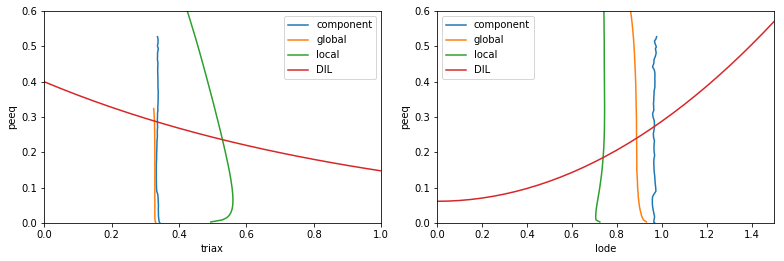

In [16]:
plot_size = (11, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)

ax1.plot(compTriax, compPeeq, label='component')
ax1.plot(globalTriax, globalPeeq, label='global')
ax1.plot(localTriax, localPeeq, label='local')
ax1.plot(DILTriax, DIL_constLode, label='DIL')
ax1.set_xlim(0, 1.0)
ax1.set_ylim(0, 0.6)
ax1.set(xlabel='triax', ylabel='peeq')
ax1.legend()

ax2.plot(compLode, compPeeq, label='component')
ax2.plot(globalLode, localPeeq, label='global')
ax2.plot(localLode, localPeeq, label='local')
ax2.plot(DILLode, DIL_constTriax, label='DIL')
ax2.set_xlim(0, 1.5)
ax2.set_ylim(0, 0.6)
ax2.set(xlabel='lode', ylabel='peeq')
ax2.legend()

plt.tight_layout()
f.subplots_adjust(top=0.88)

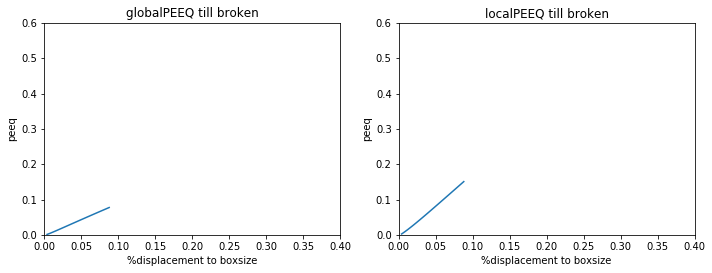

In [17]:
plot_size = (10, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)

ax1.plot(displacement[0:brokenStep], globalPeeq[0:brokenStep])
ax1.set_xlim(0, box_displace)
ax1.set_ylim(0, 0.6)
ax1.set(xlabel='%displacement to boxsize', ylabel='peeq')
ax1.title.set_text('globalPEEQ till broken')

ax2.plot(displacement[0:brokenStep], localPeeq[0:brokenStep])
ax2.set_xlim(0, box_displace)
ax2.set_ylim(0, 0.6)
ax2.set(xlabel='%displacement to boxsize', ylabel='peeq')
ax2.title.set_text('localPEEQ till broken')

plt.tight_layout()
f.subplots_adjust(top=0.88)

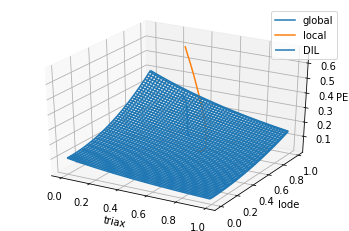

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# plot global scatter result    
xs = globalTriax
ys = globalLode
zs = globalPeeq
ax.plot(xs, ys, zs, label='global')
   
# plot local scatter result    
xs = localTriax
ys = localLode
zs = localPeeq
localPlot = ax.plot(xs, ys, zs, label='local')
   
# plot DIL
X = np.arange(0, 1, 0.01)
Y = np.arange(0, 1, 0.01)
X, Y = np.meshgrid(X, Y)
Z = df_DIL
ax.plot_wireframe(X, Y, Z, label='DIL')


# set axis label
ax.set_xlabel('triax')
ax.set_ylabel('lode')
ax.set_zlabel('PEEQ')
ax.legend()

plt.show()

In [19]:
print('broken timeStep = ' + str(brokenStep))
print('surface factor = ' + str(round(surfFactor,2)))

broken timeStep = 22
surface factor = 0.51


**Print results**

In [20]:
df_peeq.to_csv('global-localVar.csv', index=False)
df_timeStep.to_csv('Peeq-displace.csv', index=False)

In [21]:
f = open('surfFac.txt', 'w')
f.write('broken timeStep = ' + str(brokenStep) + '\n')
f.write('surface factor = ' + str(round(surfFactor,2)) + '\n')
f.close()